# Eikonal equation on N-dimensional graphs

Given an bounded domain $\Omega \subset \mathbb{R}^d$ ($d\geq 2$) we are interested to solve, 
\begin{align}
|\nabla u(x)| &= f(x) = 0, &&  x \in \Omega\\
u(x) &= 0, && x \in \partial \Omega
\end{align}

## Importing libraries

In [1]:
import os
os.chdir('../')
!bash compile.sh

running build_ext
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c flagcheck.cpp -o flagcheck.o -std=c++17
building 'monotonescheme' extension
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -DVERSION_INFO=0.0.15 -Isrc/ -I/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/pybind11/include -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c src/main.cpp -o build/temp.macosx-10.9-x86_64-3.6/src/main.o -std=c++17 -mmacosx-version-min=10.14 -fvisibility=hidden -g0 -stdlib=libc++
g++ -bundle -undefined dynamic_lookup -L/Users/wonjunlee/miniconda3/envs/cv/lib -arch 

In [2]:
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import graphlearning as gl
from scipy import sparse
import monotonescheme as ms
import plotly.graph_objects as go

# make folder if not exists
save_fig_path = 'figures'
if not os.path.exists(save_fig_path):
    os.makedirs(save_fig_path)
save_data_path = 'data'
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)

## Generating data samples

In [12]:
n = 10000 # number of points
dim = 3 # dimensions

def generate_random_point_cloud_unit_square(n, dim=2, k=20):
    X = np.random.rand(n, dim)
    W = gl.weightmatrix.knn(X,k,kernel='distance')
    return X, W
def generate_random_point_cloud_circle(n, dim=2, k=20):
    X = [[0.5]*dim]
    count = 1
    R = 0.4
    while count < n:
        z = np.random.rand(dim)
        if  np.sum((z-0.5)**2)  <= R**2:
            X.append(z)
            count += 1
    X = np.array(X)

    W = gl.weightmatrix.knn(X,k,kernel='distance')
    return X, W

def process_sparse_data(X, W):
    #Coordinates of sparse matrix for passing to C code
    I,J,V = sparse.find(W)
    K = np.array((J[1:] - J[:-1]).nonzero()) + 1
    K = np.append(0,np.append(K,len(J)))
    X = np.ascontiguousarray(X, np.float64)
    V = np.ascontiguousarray(V, np.float64)
    I = np.ascontiguousarray(I, np.int32)
    K = np.ascontiguousarray(K, np.int32)
    print(X.shape, V.shape, K.shape, I.shape)
    return X,V,I,K

X, W = generate_random_point_cloud_circle(n,dim,30) # first param: number of points # second param: number of neighbord points
mask    = (np.sum((X-0.5)**2,axis=1) > 0.37**2)
bdy_pts = np.arange(n)[mask]

# X, W = generate_random_point_cloud_unit_square(n,dim,30)
# mask    = (np.prod(np.abs(X-0.5)<0.48, axis=1) == False)
# bdy_pts = np.arange(n)[mask]

X,V,I,K = process_sparse_data(X,W)

print("data samples generated.")

(10000, 3) (322744,) (10001,) (322744,)
data samples generated.


## Initialize PDE solver

In [13]:
def get_sol_circle():
    R = 0.4
    Xc = X - 0.5
    h = np.sqrt(np.maximum(0,R**2 - np.sum(Xc**2,axis=1)))
    sol = np.pi * h**2/3.0 * (3*R - h)
    return sol
def get_sol_square():
    sol = 2 * np.minimum(X[:,0], 1 - X[:,0]) * np.minimum(X[:,1], 1 - X[:,1])
    return sol

sol = get_sol_circle()

### Running the algorithm

In [14]:
f = np.ones((n))
u = np.zeros((n))
max_it = 500
tol    = 1e-9
t = tqdm.tqdm(range(max_it), position=0)
for i in t:
    if i==0:
        solver = ms.TukeyGraph(X, V, I, K, f, bdy_pts, 'circle')
    error = solver.iterate(u)
    t.set_description_str(f'Error: {error:0.2e}')
    if error < tol:
        break
print(f"Took {t.format_dict['elapsed']:0.2f} seconds to complete.")
print(f"Error: {np.mean((sol-u)**2):0.2e}")

Error: 7.31e-03:   0%|          | 2/500 [00:00<03:15,  2.55it/s]

interior: 7861 threads:  12 count: 5109840


Error: 0.00e+00:   7%|▋         | 34/500 [00:03<00:43, 10.70it/s]

Took 3.18 seconds to complete.
Error: 6.82e-04


$$ V = \frac{\pi h^2}{3} (3r -h) $$
$$ h = R - |x| $$

### Plotting the result

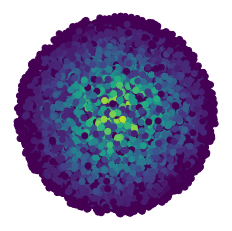

In [15]:
fig, ax = plt.subplots(1,1)
im = ax.scatter(X[:,0], X[:,1], c=u)
ax.set_aspect('equal')
ax.axis('off')
plt.show()

In [19]:
# Load data
# u = np.load(f"data/data-4.npy")
mask = ((X[:,0]<0.5) | (X[:,1]>0.5))
fig = go.Figure(data=[go.Scatter3d(x=X[:,0][mask], y=X[:,1][mask], z=X[:,2][mask],
                                   mode='markers',
                                   marker=dict(color=u[mask], size=8, colorscale='Viridis',))
                                   ])
fig.update_layout(
        scene = {
            'camera_eye': {"x": 0.5, "y": -1.6, "z": 0.6},
            # 'camera_center': {"x": 0, "y": 0, "z": 0},
            'camera_up': {"x": 0, "y": 0, "z": 1},
            'xaxis': dict(visible=False),
            'yaxis': dict(visible=False),
            'zaxis': dict(visible=False),
        },
        width=500, height=500, margin=dict(l=0, r=0, t=0, b=0)
        )

fig.show()

In [20]:
np.max(u), np.max(sol)

(0.17151866003359828, 0.13404128655316455)